# ASEN 6519 Fall 2018 - Midterm Project 
## Extended KF and Ensemble Filters with Lorenz-63

### The Lorenz-63 Model
Low-dimensional model: the state is made of 3 variables $x = (x1, x2, x3)$ and dynamical system evolution is given by the following equations:

$$\frac{\partial x_1}{\partial t} = -Ax_1 + Ax_2$$
$$\frac{\partial x_2}{\partial t} = Bx_1 - x_1x_3 - x_2$$
$$\frac{\partial x_3}{\partial t} = x_1x_2 - Cx_3$$

where $A=10$, $B=28$, and $C=8/3$.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def dfdt(r, coeffs):
    '''
    Returns dx1/dt, dx2/dt, dx3/dt
    '''
    # Current position
    x1 = r[0]
    x2 = r[1]
    x3 = r[2]
    
    # Extract coefficients
    A = coeffs[0]
    B = coeffs[1]
    C = coeffs[2]
    
    # Calculate the derivative
    dx1 = -A*x1 + A*x2
    dx2 = B*x1 - x1*x3 - x2
    dx3 = x1*x2 - C*x3
    
    return np.array([dx1, dx2, dx3], float)

### 1. Generate $true$ state and synthetic observations using Lorenz63 setup with the default inputs.

In [70]:
## Physical Parameters (default inputs)
A = 10
B = 28
C = 8/3
coeffs = np.array([A, B, C])

# Numerical parameters
t0 = 0          # sec, initial time
tf = 30          # sec, final time
N = 1000        # number of steps
h = (tf-t0)/N   # s, step size
t_hist = np.arange(t0,tf,h)   # time history

## Initial conditions
x1_hist = np.zeros([N])  # x1 history
x2_hist = np.zeros([N])
x3_hist = np.zeros([N])
x1_0 = 1
x2_0 = 1
x3_0 = 1

## Iterate through time and simulate dynamics
r = np.array([x1_0, x2_0, x3_0], float)   # "Current" position
for i in range(N):
    # Current time step (i)
    x1_hist[i] = r[0]
    x2_hist[i] = r[1]
    x3_hist[i] = r[2]
    
    # Calculate Runge-Kutta4 coefficients
    k1 = h*dfdt(r, coeffs)
    k2 = h*dfdt(r+0.5*k1, coeffs)
    k3 = h*dfdt(r+0.5*k2, coeffs)
    k4 = h*dfdt(r+k3, coeffs)
    
    # Update current position
    r += (k1 + 2*k2 + 2*k3 + k4)/6
    

In [71]:
r

array([ 5.04529685,  6.83441691, 19.26651367])

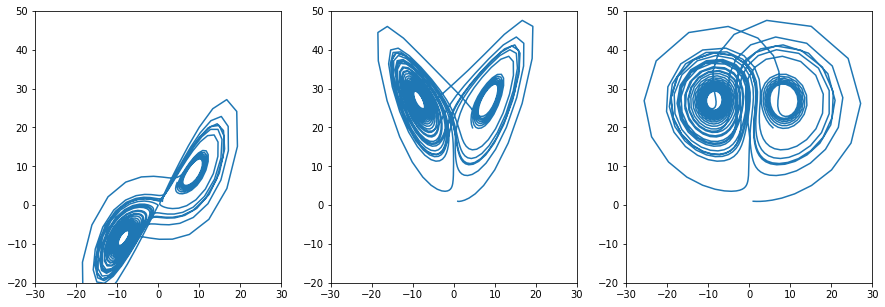

In [72]:
plt.figure(figsize=[15,5])
plt.subplot(1,3,1) ; plt.plot(x1_hist,x2_hist);plt.ylim(-20,50);plt.xlim(-30,30)
plt.subplot(1,3,2) ; plt.plot(x1_hist,x3_hist);plt.ylim(-20,50);plt.xlim(-30,30)
plt.subplot(1,3,3) ; plt.plot(x2_hist,x3_hist);plt.ylim(-20,50);plt.xlim(-30,30)
plt.show()

### 2. Implement your own EKF to estimate $x_a$. The tangent linear and adjoint codes are provided.
 - Investigate the performance of filter in terms of the bias and mean-square-error of data assimilation analysis. How does the estimate-error computed from xa and the truth value of $x$ compare to the error variance suggested by the posterior covariance?
 - Examine the sensitivity of the filter performance to the errors in the background. (Compare at least 10 cases)
 - Examine the sensitivity of the filter performance to the accuracy and frequency of observations. Is it better to have frequent but inaccurate observations or infrequent but accurate ones? (Compare at least $10\times 10$ cases.)

### 3. Implement your own EnKF (with perturb observations) or EnSRF to estimate xa.
 - Initialize the ensemble by introducing small perturbations to the state and integrating the model until its error growth saturates.
 - Compare the performance of the ensemble method to EKF with respect to each sub-question above. Launch ensemble forecasts (instead of deterministic forecasts) at the end of the assimilation period.
 - Evaluate the ensemble by using rank histograms.
 - Examine the impact of increasing or decreasing ensemble size on the filter performance as well as the forecast performance.